<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/scripts_pytorch/alphaGAN_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# alphaGAN, MNIST

- 元論文： Variational Approaches for Auto-Encoding Generative Adversarial Networks https://arxiv.org/abs/1706.04987 (2017)

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [18]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pytorch/')
from _main_base_generative import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = [str(x) for x in range(10)] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 10
cfg.INPUT_MODE = None
cfg.INPUT_CMAP = None

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # None, RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = 'gray' # pyplot cmap

# alpha GAN config
cfg.ALPHAGAN_LOSS_LAMBDA = 0.1
cfg.ALPHAGAN_EPSILON = 1e-12
cfg.ALPHAGAN_RES_DIM = 128
cfg.USE_RESBLOCK = False
cfg.G_DIM = 32
cfg.D_DIM = 32
cfg.E_DIM = 32
cfg.CD_DIM = 700

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'alphaGAN_MNIST'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_E_SAVE_PATH = 'models/' + cfg.PREFIX + '_E_{}.pt'
cfg.TRAIN.MODEL_CD_SAVE_PATH = 'models/' + cfg.PREFIX + '_CD_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 5_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_E = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_E = {'lr' : 0.0001, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_CD = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_CD = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNC_BCE = loss_fn = torch.nn.BCELoss()
cfg.TRAIN.LOSS_FUNC_L1 = torch.nn.L1Loss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 200
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 4
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_E_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_CD_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'ALPHAGAN_EPSILON': 1e-12,
 'ALPHAGAN_LOSS_LAMBDA': 0.1,
 'ALPHAGAN_RES_DIM': 128,
 'CD_DIM': 700,
 'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'CLASS_NUM': 10,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'D_DIM': 32,
 'E_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CMAP': None,
 'INPUT_MODE': None,
 'INPUT_Z_DIM': 10,
 'OUTPUT_CHANNEL': 1,
 'OUTPUT_CMAP': 'gray',
 'OUTPUT_HEIGHT': 28,
 'OUTPUT_MODE': None,
 'OUTPUT_WIDTH': 28,
 'PREFIX': 'alphaGAN_MNIST',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 4,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/alphaGAN_MNIST_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/alphaGAN_MNIST_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 5000,
  

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
    
    
class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=cfg.ALPHAGAN_RES_DIM, activation_fn=torch.nn.ReLU(), batch_norm=False):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        else:
            if batch_norm:
                self.skip_conv = torch.nn.Sequential(
                    torch.nn.BatchNorm2d(dim_first),
                    activation_fn,
                    torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                )
            else:
                self.skip_conv = torch.nn.Sequential(
                    activation_fn,
                    torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                )
        
        if batch_norm:
            self.block = torch.nn.Sequential(
                torch.nn.BatchNorm2d(dim_first),
                activation_fn,
                torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                torch.nn.BatchNorm2d(dim),
                activation_fn,
                torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            )
        else:
            self.block = torch.nn.Sequential(
                activation_fn,
                torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                activation_fn,
                torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            )

    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        return F.relu(res_x + x)

        
class Interpolate(torch.nn.Module):
    def __init__(self, scale_factor=2):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor)
        return x

    
class Generator(torch.nn.Module):
    def __init__(self, resblock=False):
        super(Generator, self).__init__()
        dim = cfg.G_DIM
        
        if resblock:
            self.module = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, dim, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], 
                                         stride=1, padding=0, bias=False), 
                torch.nn.BatchNorm2d(dim),
                torch.nn.ReLU(),
                ResBlock(dim_first=dim),
                Interpolate(),
                ResBlock(),
                Interpolate(),
                ResBlock(),
                torch.nn.Conv2d(cfg.ALPHAGAN_RES_DIM, cfg.OUTPUT_CHANNEL, kernel_size=1,
                                stride=1, padding=0),
                torch.nn.Tanh(),
            )
        else:
            self.module = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, dim * 4, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], 
                                         stride=1, padding=0, bias=False), 
                torch.nn.BatchNorm2d(dim * 4),
                torch.nn.ReLU(),
                
                torch.nn.ConvTranspose2d(dim * 4, dim * 2, kernel_size=2, stride=2, padding=0, bias=False), 
                torch.nn.BatchNorm2d(dim * 2),
                torch.nn.ReLU(),

                torch.nn.ConvTranspose2d(dim * 2, dim, kernel_size=2, stride=2, padding=0, bias=False), 
                torch.nn.BatchNorm2d(dim),
                torch.nn.ReLU(),

                #torch.nn.Conv2d(dim * 2, dim, kernel_size=3, stride=1, padding=1, bias=False),
                #torch.nn.BatchNorm2d(dim),
                #torch.nn.ReLU(),
                
                torch.nn.Conv2d(dim, cfg.OUTPUT_CHANNEL, kernel_size=1, stride=1, padding=0),
                torch.nn.Tanh(),
            )
        
    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self, resblock=False):
        super(Discriminator, self).__init__()
        dim = cfg.D_DIM
        
        if resblock:
            self.module = torch.nn.Sequential(
                ResBlock(cfg.OUTPUT_CHANNEL),
                torch.nn.AvgPool2d(2, stride=2),

                ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False),
                torch.nn.AvgPool2d(2, stride=2),

                ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False),

                ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False),
                torch.nn.ReLU(),

                torch.nn.AdaptiveAvgPool2d((1, 1)),
                Flatten(),
                #torch.nn.Linear(dim * 8 * 4 * 4, 2),
                #torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(cfg.ALPHAGAN_RES_DIM, 1),
                torch.nn.Sigmoid()
            )
        else:
            self.module = torch.nn.Sequential(
                torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, dim, kernel_size=1, stride=1, padding=0, bias=False),
                torch.nn.LeakyReLU(0.2),

                torch.nn.Conv2d(dim, dim * 2, kernel_size=5, stride=2, padding=2, bias=False),
                torch.nn.LeakyReLU(0.2),

                torch.nn.Conv2d(dim * 2, dim * 4, kernel_size=5, stride=2, padding=2, bias=False),
                torch.nn.LeakyReLU(0.2),

                torch.nn.Conv2d(dim * 4, dim * 8, kernel_size=5, stride=1, padding=2, bias=False),
                torch.nn.LeakyReLU(0.2),

                torch.nn.Conv2d(dim * 8, dim * 16, kernel_size=5, stride=1, padding=2, bias=False),
                torch.nn.LeakyReLU(0.2),

                #Flatten(),
                #torch.nn.Linear(dim * 8 * 4 * 4, 2),
                #torch.nn.LeakyReLU(0.2),
                #torch.nn.Linear(cfg.ALPHAGAN_RES_DIM, 1),
                torch.nn.Conv2d(dim * 16, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4],
                                stride=1, padding=0, bias=False),
                torch.nn.Sigmoid()
            )

    def forward(self, x):
        return self.module(x)

    
class Encoder(torch.nn.Module):
    def __init__(self, resblock=False):
        super(Encoder, self).__init__()

        dim = cfg.E_DIM
        
        if resblock:
            self.module = torch.nn.Sequential(
                torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, dim, kernel_size=3, stride=1, padding=1),
                torch.nn.BatchNorm2d(dim),
                torch.nn.ReLU(),

                ResBlock(dim_first=dim),
                torch.nn.AvgPool2d(2, stride=2, padding=0),

                ResBlock(),
                torch.nn.AvgPool2d(2, stride=2, padding=0),

                ResBlock(),

                torch.nn.Conv2d(cfg.ALPHAGAN_RES_DIM, cfg.INPUT_Z_DIM, 
                                kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], stride=1, padding=0),
                #Flatten(),
                #torch.nn.Linear(dim * 2 * (cfg.OUTPUT_HEIGHT // 4) * (cfg.OUTPUT_WIDTH // 4), cfg.INPUT_Z_DIM)
            )
        else:
            self.module = torch.nn.Sequential(
                torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, dim, kernel_size=3, stride=1, padding=1),
                torch.nn.BatchNorm2d(dim),
                torch.nn.ReLU(),

                torch.nn.Conv2d(dim, dim * 2, kernel_size=5, stride=2, padding=2),
                torch.nn.BatchNorm2d(dim * 2),
                torch.nn.ReLU(),

                torch.nn.Conv2d(dim * 2, dim * 4, kernel_size=5, stride=2, padding=2),
                torch.nn.BatchNorm2d(dim * 4),
                torch.nn.ReLU(),

                torch.nn.Conv2d(dim * 4, cfg.INPUT_Z_DIM, 
                                kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], stride=1, padding=0),
                #Flatten(),
                #torch.nn.Linear(dim * 2 * (cfg.OUTPUT_HEIGHT // 4) * (cfg.OUTPUT_WIDTH // 4), cfg.INPUT_Z_DIM)
            )
        
    def forward(self, x):
        return self.module(x)
    
class CodeDiscriminator(torch.nn.Module):
    def __init__(self):
        super(CodeDiscriminator, self).__init__()
        
        dim = cfg.CD_DIM
        
        self.module = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(cfg.INPUT_Z_DIM, dim, bias=False),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(dim, dim, bias=False),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(dim, dim, bias=False),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(dim, 1, bias=False),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.module(x)


## Utility

In [0]:
def result_show(G, Xs, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    Gz = G(Xs)
    Gz = Gz.detach().cpu().numpy()
    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    
    if cfg.OUTPUT_CHANNEL == 1:
        Gz = Gz[:, 0]
    else:
        Gz = Gz.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(Gz))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show output
        _G = Gz[i]

        plt.subplot(1, show_max, i + 1)
        plt.imshow(_G, cmap=cmap_out)
        plt.axis('off')
        plt.title(cfg.CLASS_LABEL[i])

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 7, 7]          62,720
       BatchNorm2d-2            [-1, 128, 7, 7]             256
              ReLU-3            [-1, 128, 7, 7]               0
   ConvTranspose2d-4           [-1, 64, 14, 14]          32,768
       BatchNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
   ConvTranspose2d-7           [-1, 32, 28, 28]           8,192
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10            [-1, 1, 28, 28]              33
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 104,161
Trainable params: 104,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Iter:50, LossG:0.0699, LossD:0.0000, Loss_E:0.0699, LossCD:0.0021
Iter:100, LossG:0.0445, LossD:0.0000, Loss_E:0.0445, LossCD:0.0001
Iter:150, LossG:0.0336, LossD:0.0000, Loss_E:0.0338, LossCD:0.0000
Iter:200, LossG:0.0250, LossD:0.0000, Loss_E:0.0253, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter200.pt, D >> models/alphaGAN_MNIST_D_iter200.pt
result was saved to >> result/alphaGAN_MNIST_result_iter200.jpg


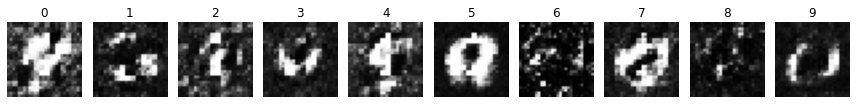

Iter:250, LossG:0.0204, LossD:0.0000, Loss_E:0.0207, LossCD:0.0000
Iter:300, LossG:0.0171, LossD:0.0000, Loss_E:0.0173, LossCD:0.0000
Iter:350, LossG:0.0146, LossD:0.0000, Loss_E:0.0149, LossCD:0.0000
Iter:400, LossG:0.0136, LossD:0.0000, Loss_E:0.0139, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter400.pt, D >> models/alphaGAN_MNIST_D_iter400.pt
result was saved to >> result/alphaGAN_MNIST_result_iter400.jpg


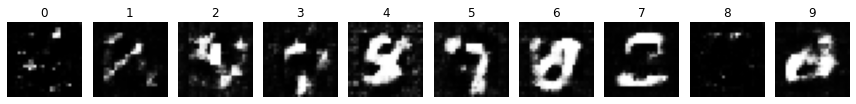

Iter:450, LossG:0.0120, LossD:0.0000, Loss_E:0.0123, LossCD:0.0000
Iter:500, LossG:0.0115, LossD:0.0000, Loss_E:0.0117, LossCD:0.0000
Iter:550, LossG:0.0112, LossD:0.0000, Loss_E:0.0115, LossCD:0.0000
Iter:600, LossG:0.0104, LossD:0.0000, Loss_E:0.0107, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter600.pt, D >> models/alphaGAN_MNIST_D_iter600.pt
result was saved to >> result/alphaGAN_MNIST_result_iter600.jpg


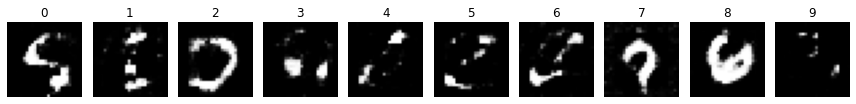

Iter:650, LossG:0.0117, LossD:0.0000, Loss_E:0.0119, LossCD:0.0000
Iter:700, LossG:0.0096, LossD:0.0000, Loss_E:0.0098, LossCD:0.0000
Iter:750, LossG:0.0090, LossD:0.0000, Loss_E:0.0093, LossCD:0.0000
Iter:800, LossG:0.0108, LossD:0.0000, Loss_E:0.0111, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter800.pt, D >> models/alphaGAN_MNIST_D_iter800.pt
result was saved to >> result/alphaGAN_MNIST_result_iter800.jpg


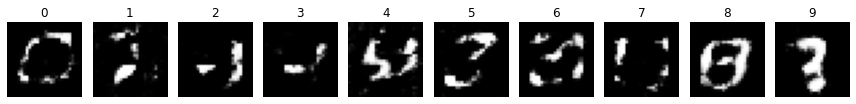

Iter:850, LossG:0.0094, LossD:0.0000, Loss_E:0.0097, LossCD:0.0000
Iter:900, LossG:0.0099, LossD:0.0000, Loss_E:0.0101, LossCD:0.0000
Iter:950, LossG:0.0084, LossD:0.0000, Loss_E:0.0087, LossCD:0.0000
Iter:1000, LossG:0.0100, LossD:0.0000, Loss_E:0.0103, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter1000.pt, D >> models/alphaGAN_MNIST_D_iter1000.pt
result was saved to >> result/alphaGAN_MNIST_result_iter1000.jpg


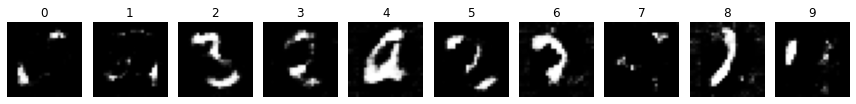

Iter:1050, LossG:0.0080, LossD:0.0000, Loss_E:0.0081, LossCD:0.0000
Iter:1100, LossG:0.0090, LossD:0.0000, Loss_E:0.0092, LossCD:0.0000
Iter:1150, LossG:0.0101, LossD:0.0000, Loss_E:0.0103, LossCD:0.0000
Iter:1200, LossG:0.0101, LossD:0.0000, Loss_E:0.0104, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter1200.pt, D >> models/alphaGAN_MNIST_D_iter1200.pt
result was saved to >> result/alphaGAN_MNIST_result_iter1200.jpg


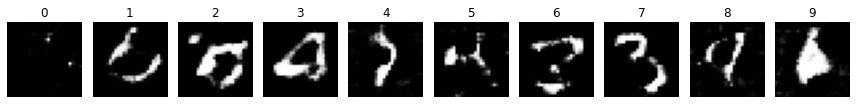

Iter:1250, LossG:0.0089, LossD:0.0000, Loss_E:0.0091, LossCD:0.0000
Iter:1300, LossG:0.0100, LossD:0.0000, Loss_E:0.0102, LossCD:0.0000
Iter:1350, LossG:0.0089, LossD:0.0000, Loss_E:0.0092, LossCD:0.0000
Iter:1400, LossG:0.0082, LossD:0.0000, Loss_E:0.0085, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter1400.pt, D >> models/alphaGAN_MNIST_D_iter1400.pt
result was saved to >> result/alphaGAN_MNIST_result_iter1400.jpg


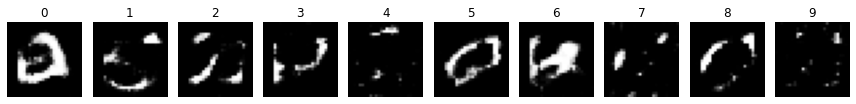

Iter:1450, LossG:0.0084, LossD:0.0000, Loss_E:0.0087, LossCD:0.0000
Iter:1500, LossG:0.0097, LossD:0.0000, Loss_E:0.0099, LossCD:0.0000
Iter:1550, LossG:0.0092, LossD:0.0000, Loss_E:0.0094, LossCD:0.0000
Iter:1600, LossG:0.0077, LossD:0.0000, Loss_E:0.0079, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter1600.pt, D >> models/alphaGAN_MNIST_D_iter1600.pt
result was saved to >> result/alphaGAN_MNIST_result_iter1600.jpg


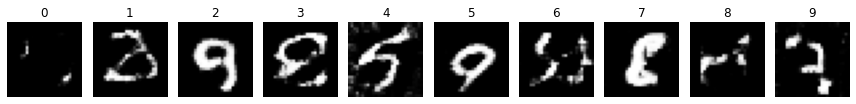

Iter:1650, LossG:0.0081, LossD:0.0000, Loss_E:0.0083, LossCD:0.0000
Iter:1700, LossG:0.0079, LossD:0.0000, Loss_E:0.0082, LossCD:0.0000
Iter:1750, LossG:0.0076, LossD:0.0000, Loss_E:0.0078, LossCD:0.0000
Iter:1800, LossG:0.0083, LossD:0.0000, Loss_E:0.0085, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter1800.pt, D >> models/alphaGAN_MNIST_D_iter1800.pt
result was saved to >> result/alphaGAN_MNIST_result_iter1800.jpg


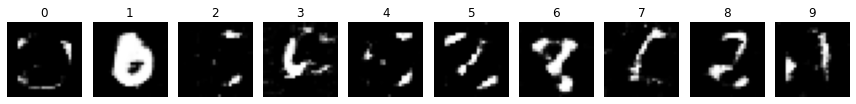

Iter:1850, LossG:0.0093, LossD:0.0000, Loss_E:0.0095, LossCD:0.0000
Iter:1900, LossG:0.0089, LossD:0.0000, Loss_E:0.0092, LossCD:0.0000
Iter:1950, LossG:0.0086, LossD:0.0000, Loss_E:0.0088, LossCD:0.0000
Iter:2000, LossG:0.0080, LossD:0.0000, Loss_E:0.0082, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter2000.pt, D >> models/alphaGAN_MNIST_D_iter2000.pt
result was saved to >> result/alphaGAN_MNIST_result_iter2000.jpg


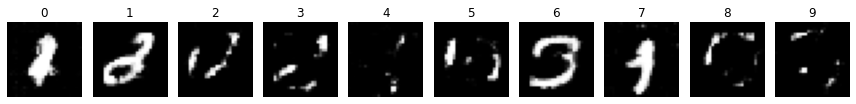

Iter:2050, LossG:0.0085, LossD:0.0000, Loss_E:0.0087, LossCD:0.0000
Iter:2100, LossG:0.0079, LossD:0.0000, Loss_E:0.0081, LossCD:0.0000
Iter:2150, LossG:0.0077, LossD:0.0000, Loss_E:0.0078, LossCD:0.0000
Iter:2200, LossG:0.0070, LossD:0.0000, Loss_E:0.0073, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter2200.pt, D >> models/alphaGAN_MNIST_D_iter2200.pt
result was saved to >> result/alphaGAN_MNIST_result_iter2200.jpg


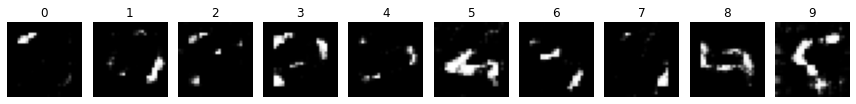

Iter:2250, LossG:0.0087, LossD:0.0000, Loss_E:0.0088, LossCD:0.0000
Iter:2300, LossG:0.0080, LossD:0.0000, Loss_E:0.0082, LossCD:0.0000
Iter:2350, LossG:0.0074, LossD:0.0000, Loss_E:0.0077, LossCD:0.0000
Iter:2400, LossG:0.0083, LossD:0.0000, Loss_E:0.0085, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter2400.pt, D >> models/alphaGAN_MNIST_D_iter2400.pt
result was saved to >> result/alphaGAN_MNIST_result_iter2400.jpg


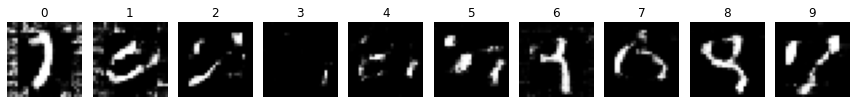

Iter:2450, LossG:0.0075, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
Iter:2500, LossG:0.0072, LossD:0.0000, Loss_E:0.0075, LossCD:0.0000
Iter:2550, LossG:0.0084, LossD:0.0000, Loss_E:0.0086, LossCD:0.0000
Iter:2600, LossG:0.0081, LossD:0.0000, Loss_E:0.0083, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter2600.pt, D >> models/alphaGAN_MNIST_D_iter2600.pt
result was saved to >> result/alphaGAN_MNIST_result_iter2600.jpg


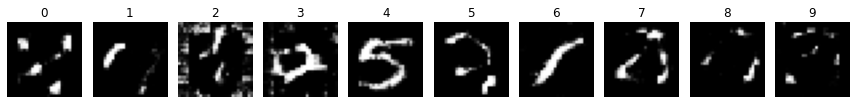

Iter:2650, LossG:0.0072, LossD:0.0000, Loss_E:0.0075, LossCD:0.0000
Iter:2700, LossG:0.0077, LossD:0.0000, Loss_E:0.0079, LossCD:0.0000
Iter:2750, LossG:0.0081, LossD:0.0000, Loss_E:0.0084, LossCD:0.0000
Iter:2800, LossG:0.0089, LossD:0.0000, Loss_E:0.0091, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter2800.pt, D >> models/alphaGAN_MNIST_D_iter2800.pt
result was saved to >> result/alphaGAN_MNIST_result_iter2800.jpg


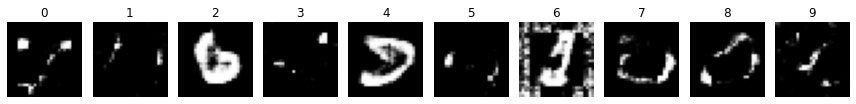

Iter:2850, LossG:0.0073, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
Iter:2900, LossG:0.0069, LossD:0.0000, Loss_E:0.0073, LossCD:0.0000
Iter:2950, LossG:0.0078, LossD:0.0000, Loss_E:0.0080, LossCD:0.0000
Iter:3000, LossG:0.0081, LossD:0.0000, Loss_E:0.0083, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter3000.pt, D >> models/alphaGAN_MNIST_D_iter3000.pt
result was saved to >> result/alphaGAN_MNIST_result_iter3000.jpg


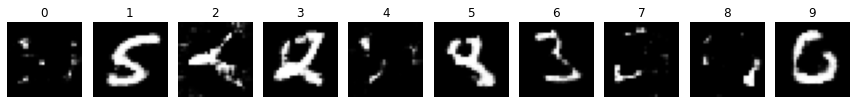

Iter:3050, LossG:0.0065, LossD:0.0000, Loss_E:0.0068, LossCD:0.0000
Iter:3100, LossG:0.0079, LossD:0.0000, Loss_E:0.0082, LossCD:0.0000
Iter:3150, LossG:0.0080, LossD:0.0000, Loss_E:0.0082, LossCD:0.0000
Iter:3200, LossG:0.0074, LossD:0.0000, Loss_E:0.0075, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter3200.pt, D >> models/alphaGAN_MNIST_D_iter3200.pt
result was saved to >> result/alphaGAN_MNIST_result_iter3200.jpg


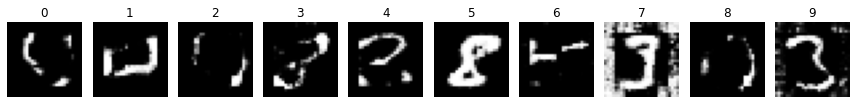

Iter:3250, LossG:0.0087, LossD:0.0000, Loss_E:0.0090, LossCD:0.0000
Iter:3300, LossG:0.0074, LossD:0.0000, Loss_E:0.0075, LossCD:0.0000
Iter:3350, LossG:0.0075, LossD:0.0000, Loss_E:0.0077, LossCD:0.0000
Iter:3400, LossG:0.0082, LossD:0.0000, Loss_E:0.0085, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter3400.pt, D >> models/alphaGAN_MNIST_D_iter3400.pt
result was saved to >> result/alphaGAN_MNIST_result_iter3400.jpg


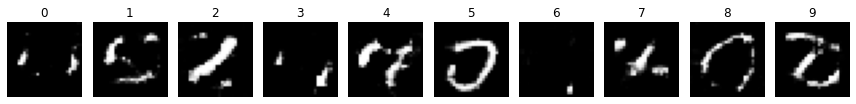

Iter:3450, LossG:0.0069, LossD:0.0000, Loss_E:0.0071, LossCD:0.0000
Iter:3500, LossG:0.0073, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
Iter:3550, LossG:0.0077, LossD:0.0000, Loss_E:0.0079, LossCD:0.0000
Iter:3600, LossG:0.0068, LossD:0.0000, Loss_E:0.0071, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter3600.pt, D >> models/alphaGAN_MNIST_D_iter3600.pt
result was saved to >> result/alphaGAN_MNIST_result_iter3600.jpg


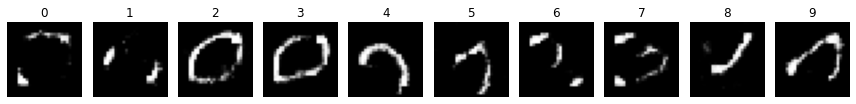

Iter:3650, LossG:0.0076, LossD:0.0000, Loss_E:0.0078, LossCD:0.0000
Iter:3700, LossG:0.0082, LossD:0.0000, Loss_E:0.0084, LossCD:0.0000
Iter:3750, LossG:0.0070, LossD:0.0000, Loss_E:0.0072, LossCD:0.0000
Iter:3800, LossG:0.0066, LossD:0.0000, Loss_E:0.0068, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter3800.pt, D >> models/alphaGAN_MNIST_D_iter3800.pt
result was saved to >> result/alphaGAN_MNIST_result_iter3800.jpg


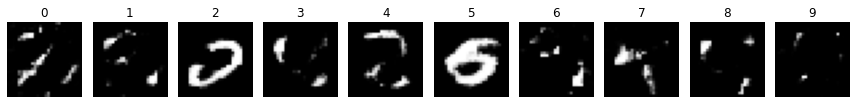

Iter:3850, LossG:0.0073, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
Iter:3900, LossG:0.0068, LossD:0.0000, Loss_E:0.0070, LossCD:0.0000
Iter:3950, LossG:0.0075, LossD:0.0000, Loss_E:0.0078, LossCD:0.0000
Iter:4000, LossG:0.0078, LossD:0.0000, Loss_E:0.0081, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter4000.pt, D >> models/alphaGAN_MNIST_D_iter4000.pt
result was saved to >> result/alphaGAN_MNIST_result_iter4000.jpg


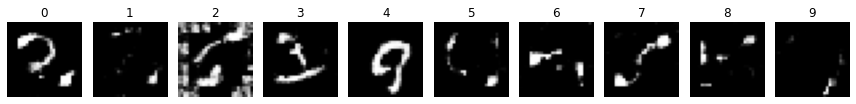

Iter:4050, LossG:0.0071, LossD:0.0000, Loss_E:0.0073, LossCD:0.0000
Iter:4100, LossG:0.0065, LossD:0.0000, Loss_E:0.0067, LossCD:0.0000
Iter:4150, LossG:0.0088, LossD:0.0000, Loss_E:0.0090, LossCD:0.0000
Iter:4200, LossG:0.0070, LossD:0.0000, Loss_E:0.0073, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter4200.pt, D >> models/alphaGAN_MNIST_D_iter4200.pt
result was saved to >> result/alphaGAN_MNIST_result_iter4200.jpg


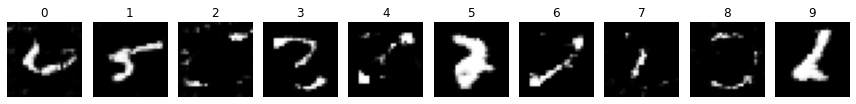

Iter:4250, LossG:0.0069, LossD:0.0000, Loss_E:0.0072, LossCD:0.0000
Iter:4300, LossG:0.0076, LossD:0.0000, Loss_E:0.0079, LossCD:0.0000
Iter:4350, LossG:0.0079, LossD:0.0000, Loss_E:0.0081, LossCD:0.0000
Iter:4400, LossG:0.0078, LossD:0.0000, Loss_E:0.0080, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter4400.pt, D >> models/alphaGAN_MNIST_D_iter4400.pt
result was saved to >> result/alphaGAN_MNIST_result_iter4400.jpg


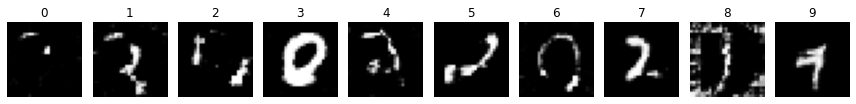

Iter:4450, LossG:0.0082, LossD:0.0000, Loss_E:0.0085, LossCD:0.0000
Iter:4500, LossG:0.0074, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
Iter:4550, LossG:0.0080, LossD:0.0000, Loss_E:0.0082, LossCD:0.0000
Iter:4600, LossG:0.0074, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter4600.pt, D >> models/alphaGAN_MNIST_D_iter4600.pt
result was saved to >> result/alphaGAN_MNIST_result_iter4600.jpg


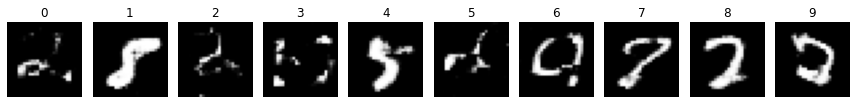

Iter:4650, LossG:0.0064, LossD:0.0000, Loss_E:0.0065, LossCD:0.0000
Iter:4700, LossG:0.0064, LossD:0.0000, Loss_E:0.0065, LossCD:0.0000
Iter:4750, LossG:0.0065, LossD:0.0000, Loss_E:0.0067, LossCD:0.0000
Iter:4800, LossG:0.0073, LossD:0.0000, Loss_E:0.0076, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter4800.pt, D >> models/alphaGAN_MNIST_D_iter4800.pt
result was saved to >> result/alphaGAN_MNIST_result_iter4800.jpg


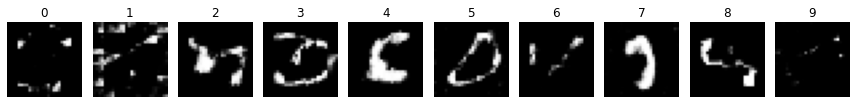

Iter:4850, LossG:0.0067, LossD:0.0000, Loss_E:0.0068, LossCD:0.0000
Iter:4900, LossG:0.0081, LossD:0.0000, Loss_E:0.0083, LossCD:0.0000
Iter:4950, LossG:0.0076, LossD:0.0000, Loss_E:0.0078, LossCD:0.0000
Iter:5000, LossG:0.0069, LossD:0.0000, Loss_E:0.0072, LossCD:0.0000
save G >> models/alphaGAN_MNIST_G_iter5000.pt, D >> models/alphaGAN_MNIST_D_iter5000.pt
result was saved to >> result/alphaGAN_MNIST_result_iter5000.jpg


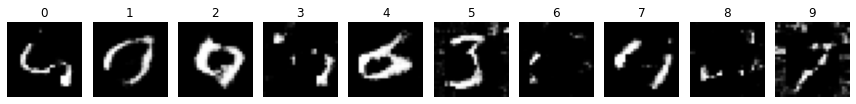

final paramters were saved to G >> models/alphaGAN_MNIST_G_final.pt, D >> models/alphaGAN_MNIST_D_final.pt
loss was saved to >> result/alphaGAN_MNIST_loss.csv


In [21]:
# train
def train():
    # model
    G = Generator(cfg.USE_RESBLOCK).to(cfg.DEVICE)
    D = Discriminator(cfg.USE_RESBLOCK).to(cfg.DEVICE)
    E = Encoder(cfg.USE_RESBLOCK).to(cfg.DEVICE)
    CD = CodeDiscriminator().to(cfg.DEVICE)
    
    summary(G, (cfg.INPUT_Z_DIM, 1, 1), device=cfg.DEVICE_TYPE)
    summary(D, (cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)
    summary(E, (cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)
    summary(CD, (cfg.INPUT_Z_DIM, 1, 1), device=cfg.DEVICE_TYPE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)
    opt_E = cfg.TRAIN.OPTIMIZER_E(E.parameters(), **cfg.TRAIN.LEARNING_PARAMS_E)
    opt_CD = cfg.TRAIN.OPTIMIZER_CD(CD.parameters(), **cfg.TRAIN.LEARNING_PARAMS_CD)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = np.array(trainset.data)
    train_ys = np.array(trainset.targets)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_G_fake = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_E = []
    list_loss_E_fake = []
    list_loss_CD = []
    list_loss_CD_real = []
    list_loss_CD_fake = []
    list_loss_recon = []
    
    ones = torch.zeros([cfg.TRAIN.MINIBATCH, 1], dtype=torch.float).to(cfg.DEVICE)
    zeros = ones * 0

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # sample X
        Xs_real = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ys = train_ys[mb_ind]
        
        # sample x
        z_real = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z_real = torch.tensor(z_real, dtype=torch.float).to(cfg.DEVICE)

        # forward

        # x_real > E > z_real > CD
        # z_real = E(Xs_real)
        # CD_z_real = CD(z_real)
        
        # # x_real > E > z_real > G > D
        # G_z_real = G(z_real)
        # D_z_real = D(G_z_real)
        
        # # z_fake > CD
        # CD_z_fake = CD(z_fake)
        
        # # z_fake > G > x_fake > D
        # x_fake = G(z_fake)
        # D_x_fake = D(x_fake)
        
        # # x_real > D
        # D_x_real = D(Xs_real)
        
        # encoder update
        opt_E.zero_grad()
        loss_E_fake = cfg.TRAIN.LOSS_FUNC_BCE(CD(E(Xs_real)), zeros)
        loss_recon = cfg.ALPHAGAN_LOSS_LAMBDA * cfg.TRAIN.LOSS_FUNC_L1(Xs_real, G(E(Xs_real)))
        loss_E = loss_E_fake + loss_recon
        loss_E.backward(retain_graph=True)
        opt_E.step()
        
        # generator update
        opt_G.zero_grad()
        loss_G_fake = cfg.TRAIN.LOSS_FUNC_BCE(D(G(z_real)), ones)
        loss_recon = cfg.ALPHAGAN_LOSS_LAMBDA * cfg.TRAIN.LOSS_FUNC_L1(Xs_real, G(E(Xs_real)))
        loss_G = loss_G_fake + loss_recon
        loss_G.backward(retain_graph=True)
        for _ in range(2):
            opt_G.step()
        
        # discriminator update
        opt_D.zero_grad()
        loss_D_real = cfg.TRAIN.LOSS_FUNC_BCE(D(Xs_real), ones)
        loss_D_fake = cfg.TRAIN.LOSS_FUNC_BCE(D(G(z_real)), zeros)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        opt_D.step()
    
        # code discriminator loss
        opt_CD.zero_grad()
        loss_CD_real = cfg.TRAIN.LOSS_FUNC_BCE(CD(z_real), zeros)
        loss_CD_fake = cfg.TRAIN.LOSS_FUNC_BCE(CD(E(Xs_real)), ones)
        loss_CD = loss_CD_real + loss_CD_fake
        loss_CD.backward()
        opt_CD.step()

        _loss_G = loss_G.item()
        _loss_G_fake = loss_G_fake.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _loss_E = loss_E.item()
        _loss_E_fake = loss_E_fake.item()
        _loss_CD = loss_CD.item()
        _loss_CD_real = loss_CD_real.item()
        _loss_CD_fake = loss_CD_fake.item()
        _loss_recon = loss_recon.item()
        
        progres_bar += '|'
        print('\r' + progres_bar, end='')

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_G_fake.append(_loss_G_fake)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_E.append(_loss_E)
                list_loss_E_fake.append(_loss_E_fake)
                list_loss_CD.append(_loss_CD)
                list_loss_CD_real.append(_loss_CD_real)
                list_loss_CD_fake.append(_loss_CD_fake)
                list_loss_recon.append(_loss_recon)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG:{:.4f}, LossD:{:.4f}, Loss_E:{:.4f}, LossCD:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_E, _loss_CD))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            E_save_path = cfg.TRAIN.MODEL_E_SAVE_PATH.format('iter{}'.format(i + 1))
            CD_save_path = cfg.TRAIN.MODEL_CD_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            torch.save(E.state_dict(), E_save_path)
            torch.save(CD.state_dict(), CD_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z_real, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)


    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    E_save_path = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final')
    CD_save_path = cfg.TRAIN.MODEL_CD_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    torch.save(E.state_dict(), G_save_path)
    torch.save(CD.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_G_fake' : list_loss_G_fake,
                           'loss_D' : list_loss_D, 'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake,
                          'loss_E' : list_loss_E, 'loss_E_fake' : list_loss_E_fake, 'loss_CD' : list_loss_CD,
                           'loss_CD_real' : list_loss_CD_real, 'loss_CD_fake' : list_loss_CD_fake,
                           'loss_reconstruction' : list_loss_recon
                          })
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

In [0]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.CLASS_NUM, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        #  add conditional
        z_con = torch.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM, 1, 1], dtype=torch.float).to(cfg.DEVICE)
        z_con[range(cfg.CLASS_NUM), range(cfg.CLASS_NUM)] = 1
        z = torch.cat([z, z_con], dim=1)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, 
                   show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
